In [94]:
# cell 1
import os
import time
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from mplfinance.original_flavor import candlestick_ohlc

# ensure output folder
os.makedirs("scanner_output", exist_ok=True)

def compute_rsi(close, period=14):
    delta = close.diff()
    gain  = delta.clip(lower=0)
    loss  = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

# ————————————— Compute MACD —————————————
def compute_macd(df, fast=12, slow=26, signal=9):
    ema_fast   = df["close"].ewm(span=fast,  adjust=False).mean()
    ema_slow   = df["close"].ewm(span=slow,  adjust=False).mean()
    macd_line  = ema_fast - ema_slow
    sig_line   = macd_line.ewm(span=signal, adjust=False).mean()
    hist       = macd_line - sig_line
    df["macd"]         = macd_line
    df["macd_signal"]  = sig_line
    df["macd_hist"]    = hist
    return df

def volume_metrics(df, vol_spike_ratio=1.5, vol_avg_window=20):
    df["avg_vol"]   = df["volume"].rolling(vol_avg_window, min_periods=1).mean()
    df["vol_spike"] = df["volume"] > vol_spike_ratio * df["avg_vol"]
    return df

def local_extrema(df, kind="min", order=5):
    func = np.less_equal if kind=="min" else np.greater_equal
    idx  = argrelextrema(df["close"].values, func, order=order)[0]
    return df.iloc[idx]

def find_trendlines(df, extrema, tolerance=1.5, min_touches=3):
    x = extrema.index.to_numpy(dtype=float)
    y = extrema["close"].to_numpy(dtype=float)
    lines = []
    n = len(x)
    if n < 2:
        return lines

    for i in range(n - 1):
        for j in range(i + 1, n):
            x1, x2 = x[i], x[j]
            y1, y2 = y[i], y[j]
            if x2 == x1:
                continue
            m = (y2 - y1) / (x2 - x1)
            b = y1 - m * x1

            # which extrema lie within tolerance of the line?
            mask = np.abs(y - (m * x + b)) < tolerance
            touches = int(mask.sum())
            if touches < min_touches:
                continue

            # compute span = max(x[mask]) - min(x[mask])
            # old: span = float(x[mask].ptp())
            span = float(np.ptp(x[mask]))

            lines.append({
                "slope":     float(m),
                "intercept": float(b),
                "touches":   touches,
                "span":      span
            })

    return lines

def signal_on_last(df, lines, is_support=True):
    """Returns list of (type,m,b,price_today)"""
    sigs = []
    c = df["close"].to_numpy(dtype=float)
    if c.size<2: return sigs
    p_yest, p_today = c[-2], c[-1]
    i_yest, i_today = c.size-2, c.size-1
    for L in lines:
        m,b = L if isinstance(L, tuple) else (L["slope"],L["intercept"])
        ly = m*i_yest + b
        lt = m*i_today + b
        if is_support and p_yest<ly and p_today>lt:
            sigs.append(("Buy", m,b, float(p_today)))
        if not is_support and p_yest>ly and p_today<lt:
            sigs.append(("Sell",m,b, float(p_today)))
    return sigs

def backtest_flip(signals, closes):
    c = closes.to_numpy(dtype=float)
    if c.size<2 or not signals:
        return dict(trades=0,
                    win_rate=np.nan,
                    cum_ret=0.0,
                    buy_hold=(c[-1]-c[0])/c[0]*100 if c.size>1 else 0.0)
    sigs = sorted(signals, key=lambda s:s[3])
    pos = None; entry=None; returns=[]
    for _,typ,m,b, _ in [(s[0],s[0],s[1],s[2],s[3]) for s in sigs]:
        # always evaluate exit at last price
        px = c[-1]
        if pos is None:
            pos = typ
            entry = px
        else:
            ret = (px-entry)/entry if pos=="Buy" else (entry-px)/entry
            returns.append(ret)
            pos = typ; entry=px
    # final exit
    final = c[-1]
    returns.append((final-entry)/entry if pos=="Buy" else (entry-final)/entry)
    wins = [r for r in returns if r>0]
    return dict(trades=len(returns),
                win_rate=len(wins)/len(returns)*100,
                cum_ret=(np.prod([1+r for r in returns])-1)*100,
                buy_hold=(c[-1]-c[0])/c[0]*100)

def is_hammer(open_, high, low, close):
    body  = abs(close - open_)
    lower = min(open_, close) - low
    upper = high - max(open_, close)
    total = high - low

    # lower shadow at least twice the body,
    # upper shadow very small, body small vs range
    return (
        lower > 2 * body and
        upper < 0.3 * body and
        body < 0.3 * total
    )


In [83]:
import yfinance as yf

tickers = ["AAPL","NVDA","SPY","PLTR"]
data = {}

for tk in tickers:
    df = (
        yf.download(tk, period="6mo", interval="1d", progress=False)
          .dropna()
          .reset_index()                         # pull “Date” back out of the index
    )
    # if you want to use adjusted-close as your “close” price:
    # df["close"] = df["adj_close"]
    # df = df.drop(columns="adj_close")
    
    # tack on a ticker column
    df["ticker"] = tk
    
    # reorder however you like
    df.columns = ['date', 'close', 'high', 'low', 'open', 'volume', 'stock']
    
    data[tk] = df

# now
data["AAPL"].head()


,date,close,high,low,open,volume,stock
0,2024-10-24,230.063675,230.313126,227.908415,229.474959,31109500,AAPL
1,2024-10-25,230.901810,232.707832,229.065854,229.235479,38802300,AAPL
2,2024-10-28,232.887436,234.214517,232.039312,232.807625,36087100,AAPL
3,2024-10-29,233.156845,233.815399,231.809819,232.588105,35417200,AAPL
4,2024-10-30,229.594681,232.957275,229.045886,232.099163,47070900,AAPL


In [89]:
df = data['NVDA']

In [ ]:
# In [5]: find extrema & trendlines for AAPL
df["rsi_14"] = compute_rsi(df["close"], period=14)
df["rsi_signal"] = np.where(df["rsi_14"] < 30, "oversold",
                     np.where(df["rsi_14"] > 70, "overbought", "neutral"))

df = compute_macd(df)
df["macd_cross"] = np.where(
    (df["macd"].shift(1) < df["macd_signal"].shift(1)) &
    (df["macd"]     > df["macd_signal"]),
    "bull_cross",
    np.where(
        (df["macd"].shift(1) > df["macd_signal"].shift(1)) &
        (df["macd"]     < df["macd_signal"]),
        "bear_cross", ""
    )
)

df = volume_metrics(df)

# 5) find trendlines
lows      = local_extrema(df, "min", order=5)
highs     = local_extrema(df, "max", order=5)
sup_cands = find_trendlines(df, lows,  tolerance=1.5, min_touches=3)
res_cands = find_trendlines(df, highs, tolerance=1.5, min_touches=3)
sup_cands.sort(key=lambda L: (L["touches"], L["span"]), reverse=True)
res_cands.sort(key=lambda L: (L["touches"], L["span"]), reverse=True)
top_sup = sup_cands[:2]
top_res = res_cands[:2]
print("Top support lines:",    top_sup)
print("Top resistance lines:", top_res)

# 6) per-row signals
if top_sup and top_res:
    m_sup, b_sup = top_sup[0]["slope"], top_sup[0]["intercept"]
    m_res, b_res = top_res[0]["slope"], top_res[0]["intercept"]
    x = np.arange(len(df), dtype=float)
    df["dist_sup"] = np.abs(df["close"] - (m_sup * x + b_sup))
    df["dist_res"] = np.abs(df["close"] - (m_res * x + b_res))
else:
    df["dist_sup"] = df["dist_res"] = np.nan

# 6) per-row trendline breakout signals (unchanged)
trend_signals = []
for i in range(len(df)):
    slice_df = df.iloc[: i+1]
    sup_hit = bool(signal_on_last(slice_df, top_sup, True))
    res_hit = bool(signal_on_last(slice_df, top_res, False))
    ds = df["dist_sup"].iat[i]
    dr = df["dist_res"].iat[i]

    if sup_hit and ds <= dr:
        trend_signals.append("Buy")
    elif res_hit and dr <= ds:
        trend_signals.append("Sell")
    else:
        trend_signals.append("")

df["trendline_signal"] = trend_signals

# — 6.x) per‐row breakthrough (reversal) signals —
breakthrough_signals = []
for i in range(len(df)):
    # no signal on first bar
    if i == 0:
        breakthrough_signals.append("")
        continue

    # yesterday & today prices
    p_yest  = df["close"].iat[i-1]
    p_today = df["close"].iat[i]

    # line levels yesterday & today
    ly_sup_yest   = m_sup * (i-1) + b_sup
    ly_sup_today  = m_sup * i     + b_sup
    ly_res_yest   = m_res * (i-1) + b_res
    ly_res_today  = m_res * i     + b_res

    # reversal UP: price breaks UP through the resistance line
    if (p_yest < ly_res_yest
        and p_today > ly_res_today
        and df["dist_res"].iat[i] <= df["dist_sup"].iat[i]):
        breakthrough_signals.append("reversal_up")

        if up_rev and df["hammer"].iat[i] and df["vol_spike"].iat[i]:
            breakthrough_signals.append("reversal_up")

    # reversal DOWN: price breaks DOWN through the support line
    elif (p_yest > ly_sup_yest
          and p_today < ly_sup_today
          and df["dist_sup"].iat[i] <= df["dist_res"].iat[i]):
        breakthrough_signals.append("reversal_down")

    else:
        breakthrough_signals.append("")

df["breakthrough_signal"] = breakthrough_signals

# 7) composite_signal with distance filter
df["composite_signal"] = ""

buy_mask = (
    (df["trendline_signal"] == "Buy") &
    (df["macd_cross"]        == "bull_cross") &
    (df["rsi_14"]            <  30) &
    (df["dist_sup"]          <= df["dist_res"])
)
sell_mask = (
    (df["trendline_signal"] == "Sell") &
    (df["macd_cross"]        == "bear_cross") &
    (df["rsi_14"]            >  70) &
    (df["dist_res"]          <= df["dist_sup"])
)

df.loc[buy_mask,  "composite_signal"] = "Buy"
df.loc[sell_mask, "composite_signal"] = "Sell"

# 8) (optional) print out last composite
if df["composite_signal"].iat[-1]:
    last = df.iloc[-1]
    print(f"🚀 Composite {last.composite_signal} at {last.close:.2f}")
else:
    print("No composite signal on last bar.")

df["hammer"] = df.apply(
    lambda r: is_hammer(r.open, r.high, r.low, r.close),
    axis=1
)




Top support lines: [{'slope': -0.39009931610851756, 'intercept': 143.72192159513148, 'touches': 5, 'span': 96.0}, {'slope': -0.4000856081644694, 'intercept': 144.9202766418457, 'touches': 4, 'span': 96.0}]
Top resistance lines: [{'slope': -0.35068184988839285, 'intercept': 154.9357452392578, 'touches': 4, 'span': 85.0}, {'slope': -0.34995007870802236, 'intercept': 154.91525564620744, 'touches': 4, 'span': 85.0}]
No composite signal on last bar.


# Calculate returns and Backtest

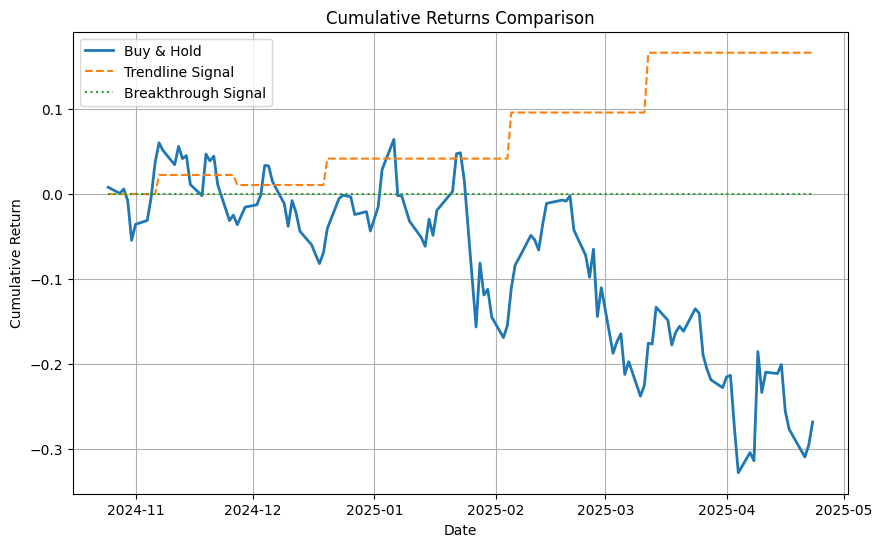

Buy & Hold Total Return:          -26.84%
Trendline Signal Total Return:     16.65%
Breakthrough Signal Total Return:   0.00%


In [101]:
import matplotlib.pyplot as plt

# 1) Compute daily simple returns
df["ret"] = df["close"].pct_change()

# 2) Buy-and-Hold cumulative return
df["cumret_bh"] = (1 + df["ret"]).cumprod() - 1

# 3) Generic backtest helper
def backtest_signal(df, signal_col):
    bt = df[["date","ret", signal_col]].copy()
    # build position: 1 on Buy, 0 on Sell or flat
    bt["pos"] = 0
    bt.loc[ bt[signal_col]=="Buy",  "pos"] = 1
    bt.loc[ bt[signal_col]=="Sell", "pos"] = 0
    # carry forward and shift so we trade next bar
    bt["pos"] = bt["pos"].ffill().shift().fillna(0)
    # apply returns
    bt["strat_ret"]    = bt["pos"] * bt["ret"]
    bt["cumret_strat"] = (1 + bt["strat_ret"]).cumprod() - 1
    return bt

# 4) Run backtests
trend_bt = backtest_signal(df, "trendline_signal")
rev_bt   = backtest_signal(df, "breakthrough_signal")

# 5) Plot them together
plt.figure(figsize=(10,6))
plt.plot(df["date"],          df["cumret_bh"],    label="Buy & Hold",    linewidth=2)
plt.plot(trend_bt["date"],    trend_bt["cumret_strat"], label="Trendline Signal", linestyle="--")
plt.plot(rev_bt["date"],      rev_bt["cumret_strat"],   label="Breakthrough Signal", linestyle=":")
plt.title("Cumulative Returns Comparison")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

# 6) Print final numbers
print(f"Buy & Hold Total Return:          {df['cumret_bh'].iat[-1]*100:6.2f}%")
print(f"Trendline Signal Total Return:    {trend_bt['cumret_strat'].iat[-1]*100:6.2f}%")
print(f"Breakthrough Signal Total Return: {rev_bt['cumret_strat'].iat[-1]*100:6.2f}%")


In [100]:
df[df['position']=='1']

,date,close,high,low,open,volume,stock,rsi_14,rsi_signal,macd,...,up_bar,hammer,log_ret,cum_log_bh,cumret_bh_log,ret,cumret_bh,position,ret_strat,cumret_strat


In [92]:
# df = data['NVDA']

# Graph prices, vol, macd and signals

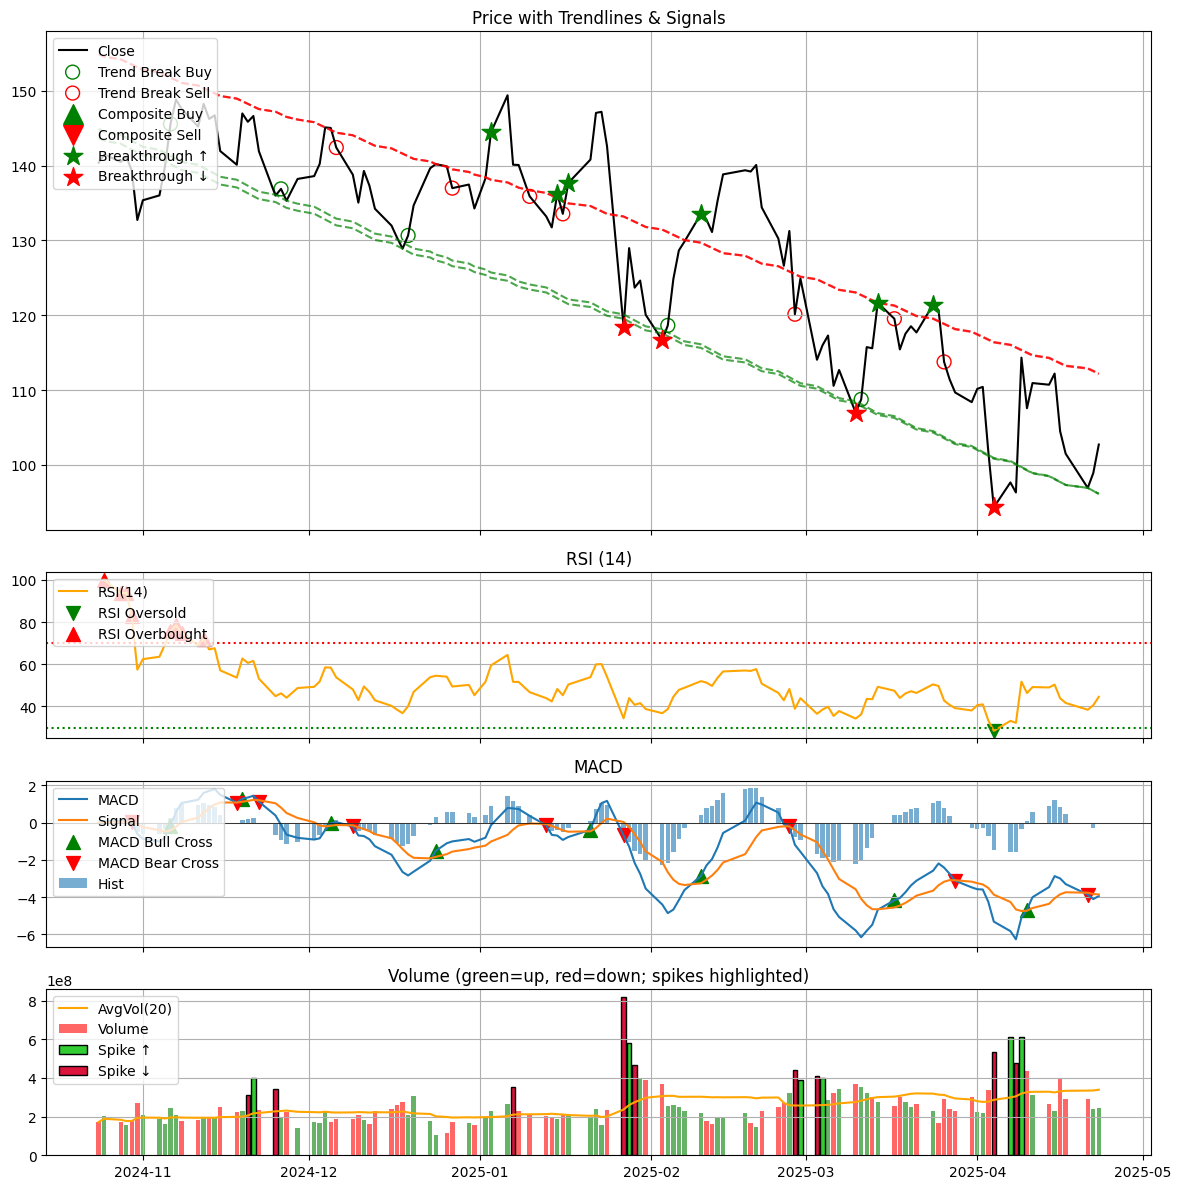

In [93]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    4, 1, figsize=(12,12), sharex=True,
    gridspec_kw={"height_ratios":[3,1,1,1]}
)

# — Price + Trendlines + Trend & Composite Signals —
ax1.plot(df.date, df.close, color="black", label="Close")
for L in top_sup + top_res:
    x = np.arange(len(df), dtype=float)
    ax1.plot(df.date, L["slope"]*x + L["intercept"],
             linestyle="--",
             color=("green" if L in top_sup else "red"),
             alpha=0.7)

# hollow circles for pure trendline breaks
mask_tb  = df["trendline_signal"]=="Buy"
mask_ts  = df["trendline_signal"]=="Sell"
ax1.scatter(df.date[mask_tb], df.close[mask_tb],
            facecolors="none", edgecolors="green", marker="o", s=100,
            label="Trend Break Buy")
ax1.scatter(df.date[mask_ts], df.close[mask_ts],
            facecolors="none", edgecolors="red",   marker="o", s=100,
            label="Trend Break Sell")

# filled arrows for composite
mask_cb  = df["composite_signal"]=="Buy"
mask_cs  = df["composite_signal"]=="Sell"
ax1.scatter(df.date[mask_cb], df.close[mask_cb],
            marker="^", color="green", s=200, label="Composite Buy")
ax1.scatter(df.date[mask_cs], df.close[mask_cs],
            marker="v", color="red",   s=200, label="Composite Sell")

# — stars for breakthrough reversals —
mask_rev_up   = df["breakthrough_signal"] == "reversal_up"
mask_rev_down = df["breakthrough_signal"] == "reversal_down"

ax1.scatter(
    df.date[mask_rev_up], df.close[mask_rev_up],
    marker="*", s=200, color="green", label="Breakthrough ↑", zorder=6
)
ax1.scatter(
    df.date[mask_rev_down], df.close[mask_rev_down],
    marker="*", s=200, color="red",   label="Breakthrough ↓", zorder=6
)

ax1.set_title("Price with Trendlines & Signals")
ax1.legend(loc="upper left"); ax1.grid(True)


# — RSI + Oversold/Overbought Signals —
ax2.plot(df.date, df.rsi_14, color="orange", label="RSI(14)")
ax2.axhline(70, color="red", linestyle=":")
ax2.axhline(30, color="green", linestyle=":")

mask_ov  = df["rsi_signal"]=="oversold"
mask_ob  = df["rsi_signal"]=="overbought"
ax2.scatter(df.date[mask_ov], df.rsi_14[mask_ov],
            marker="v", color="green", s=100, label="RSI Oversold")
ax2.scatter(df.date[mask_ob], df.rsi_14[mask_ob],
            marker="^", color="red",   s=100, label="RSI Overbought")

ax2.set_title("RSI (14)")
ax2.legend(loc="upper left"); ax2.grid(True)


# — MACD + Bull/Bear Cross Signals —
ax3.plot(df.date,       df.macd,        label="MACD")
ax3.plot(df.date,       df.macd_signal, label="Signal")
ax3.bar(df.date, df.macd_hist, alpha=0.6, label="Hist")
ax3.axhline(0, color="black", linewidth=0.5)

mask_mb = df["macd_cross"]=="bull_cross"
mask_mr = df["macd_cross"]=="bear_cross"
ax3.scatter(df.date[mask_mb], df.macd[mask_mb],
            marker="^", color="green", s=100, label="MACD Bull Cross")
ax3.scatter(df.date[mask_mr], df.macd[mask_mr],
            marker="v", color="red",   s=100, label="MACD Bear Cross")

ax3.set_title("MACD")
ax3.legend(loc="upper left"); ax3.grid(True)


# — Volume —
# — Volume (with spike highlight) —
# 1) Determine bar direction
df["up_bar"] = df["close"] > df["close"].shift(1)

# 2) Prepare spike masks
mask_spike       = df["vol_spike"]
mask_spike_up    = mask_spike & df["up_bar"]
mask_spike_down  = mask_spike & ~df["up_bar"]

# 3) Plot volume with directional coloring…
ax4.bar(
    df["date"],
    df["volume"],
    color=np.where(df["up_bar"], "green", "red"),
    alpha=0.6,
    label="Volume"
)

# …then over‐paint spikes with brighter/darker hues
ax4.bar(
    df.loc[mask_spike_up,   "date"],
    df.loc[mask_spike_up,   "volume"],
    color="limegreen",
    edgecolor="black",
    label="Spike ↑"
)
ax4.bar(
    df.loc[mask_spike_down, "date"],
    df.loc[mask_spike_down, "volume"],
    color="crimson",
    edgecolor="black",
    label="Spike ↓"
)

# 4) AvgVol line & styling
ax4.plot(df["date"], df["avg_vol"], color="orange", label="AvgVol(20)")
ax4.set_title("Volume (green=up, red=down; spikes highlighted)")
ax4.legend(loc="upper left")
ax4.grid(True)


plt.tight_layout()
plt.show()
